In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.optimize import fmin_powell

In [2]:
# Global constants
columns_to_exclude = ['Id', 'Response']
xgb_num_rounds = 720
num_classes = 8
missing_value_indicator = -1000


In [3]:
print("Loading data using pandas")
all_data = pd.read_csv("train.csv")
all_data.head()


Loading data using pandas


,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [4]:
all_data.dtypes

Id                      int64
Product_Info_1          int64
Product_Info_2         object
Product_Info_3          int64
Product_Info_4        float64
                       ...   
Medical_Keyword_45      int64
Medical_Keyword_46      int64
Medical_Keyword_47      int64
Medical_Keyword_48      int64
Response                int64
Length: 128, dtype: object

In [5]:
all_data.describe()

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,...,0.056954,0.010054,0.045536,0.010710,0.007528,0.013691,0.008488,0.019905,0.054496,5.636837
std,22815.883089,0.160191,5.072885,0.282562,0.083107,0.739103,0.291949,0.197190,0.074239,0.089037,...,0.231757,0.099764,0.208479,0.102937,0.086436,0.116207,0.091737,0.139676,0.226995,2.456833
min,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19780.000000,1.000000,26.000000,0.076923,2.000000,3.000000,1.000000,0.238806,0.654545,0.225941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,39487.000000,1.000000,26.000000,0.230769,2.000000,3.000000,1.000000,0.402985,0.709091,0.288703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,59211.000000,1.000000,26.000000,0.487179,2.000000,3.000000,1.000000,0.567164,0.763636,0.345188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,79146.000000,2.000000,38.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [6]:
# Determine which columns contain nulls/missing values.
cols_with_missing = [col for col in all_data.columns
                     if all_data[col].isnull().any()]

# Summarise how many missing values are present in each column.
all_data[cols_with_missing].isna().sum()

Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
dtype: int64

In [7]:
## Calculate the proportion of zeroes relative to non-zero values.
for col in cols_with_missing:
    sum = all_data[col].isna().sum()
    length = len(all_data[col].index)
    ratio = sum/length
    print('Proportion of zeroes in', col, 'is: ', round(ratio*100,2), '%.')

Proportion of zeroes in Employment_Info_1 is:  0.03 %.
Proportion of zeroes in Employment_Info_4 is:  11.42 %.
Proportion of zeroes in Employment_Info_6 is:  18.28 %.
Proportion of zeroes in Insurance_History_5 is:  42.77 %.
Proportion of zeroes in Family_Hist_2 is:  48.26 %.
Proportion of zeroes in Family_Hist_3 is:  57.66 %.
Proportion of zeroes in Family_Hist_4 is:  32.31 %.
Proportion of zeroes in Family_Hist_5 is:  70.41 %.
Proportion of zeroes in Medical_History_1 is:  14.97 %.
Proportion of zeroes in Medical_History_10 is:  99.06 %.
Proportion of zeroes in Medical_History_15 is:  75.1 %.
Proportion of zeroes in Medical_History_24 is:  93.6 %.
Proportion of zeroes in Medical_History_32 is:  98.14 %.


In [8]:
# These columns have been selected as they contain a high proportion of blanks/missing values (deemed here as >40%) in the TRAINING dataset.
cols_to_delete_due_to_missing_data = ['Insurance_History_5',
                                      'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_5',
                                      'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32']

# Delete columns from ALL datasets where the proportion of zeroes in the TRAINING dataset exceeds a stipulated threshold.
#all_data = all_data.drop(cols_to_delete_due_to_missing_data, axis=1)

In [9]:

# Feature engineering
all_data['Product_Info_2_char'] = all_data['Product_Info_2'].str[0]
all_data['Product_Info_2_num'] = all_data['Product_Info_2'].str[1]

# Factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

# print('Eliminating missing values')
all_data.fillna(missing_value_indicator, inplace=True)

# Fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)


In [10]:
# Split train and test
training_set = all_data[all_data['Response'] > 0].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    training_set.drop(columns_to_exclude, axis=1),
    training_set['Response'].values,
    train_size=0.8,
    test_size=0.2,
    random_state=0,
    stratify=training_set['Response'].values
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.75, test_size=0.25, random_state=0, stratify=y_train)

In [11]:
pd.options.display.max_columns = X_train.shape[1]
X_train.describe(include='all')

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Product_Info_2_char,Product_Info_2_num,BMI_Age,Med_Keywords_Count
count,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.00000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000,35628.000000
mean,1

In [12]:
df_numerical_features = X_train.select_dtypes(include='number')
df_categorical_features = X_train.select_dtypes(include='category')
print('Numeric : ',df_numerical_features.columns)
print('Categorical : ',df_categorical_features.columns)

Numeric :  Index(['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt',
       ...
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Product_Info_2_char', 'Product_Info_2_num', 'BMI_Age',
       'Med_Keywords_Count'],
      dtype='object', length=130)
Categorical :  Index([], dtype='object')


In [13]:
#There is no need for categorical feature processing, we will be using tree based algorithms so normalising/scaling is not required as those algorithms are not sensitive to this pre-processing.
#We did expleriment with/without normalising but the results were not significant to make the extra computation.

In [14]:
#
# Quadratic Weighted Kappa objective
#
def kappa_weights(n):
    s = np.linspace(1, n, n)
    w = np.power(np.subtract.outer(s, s), 2.0) / np.power(np.subtract.outer(n, np.ones((n,))), 2)
    return w


def quadratic_weighted_kappa(a, b, n=8):
    a = np.clip(a.astype('int32') - 1, 0, n - 1)
    b = np.clip(b.astype('int32') - 1, 0, n - 1)

    sa = coo_matrix((np.ones(len(a)), (np.arange(len(a)), a)), shape=(len(a), n))
    sb = coo_matrix((np.ones(len(b)), (np.arange(len(b)), b)), shape=(len(a), n))

    O = (sa.T.dot(sb)).toarray()
    E = np.outer(sa.sum(axis=0), sb.sum(axis=0))
    E = np.divide(E, np.sum(E)) * O.sum()
    W = kappa_weights(n)

    return 1.0 - np.multiply(O, W).sum() / np.multiply(E, W).sum()



def eval_wrapper(yhat, y):
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
    return quadratic_weighted_kappa(yhat, y)

# XGBoost parameters
def get_xgb_params():
    params = {
        "objective": "reg:linear",
        "eta": 0.05,
        "min_child_weight": 360,
        "subsample": 0.85,
        "colsample_bytree": 0.3,
        "silent": 1,
        "max_depth": 7
    }
    return list(params.items())


In [15]:
#This is before feature selection, basically we are letting the xgboost assign feature importance

In [17]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)

# XGBoost model training
xgtrain = xgb.DMatrix(X_train, y_train, missing=missing_value_indicator)
xgvalidation = xgb.DMatrix(X_valid, y_valid, missing=missing_value_indicator)
xgtest = xgb.DMatrix(X_test, y_test, missing=missing_value_indicator)


xgb_params_list = get_xgb_params()
print(xgb_params_list)

model = xgb.train(xgb_params_list, xgtrain, xgb_num_rounds)

# Get feature importance
train_predictions = model.predict(xgtrain)
print('Train score is:', eval_wrapper(train_predictions, y_train))


[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 360), ('subsample', 0.85), ('colsample_bytree', 0.3), ('silent', 1), ('max_depth', 7)]


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:19:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:19:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Train score is: 0.6499417567407968


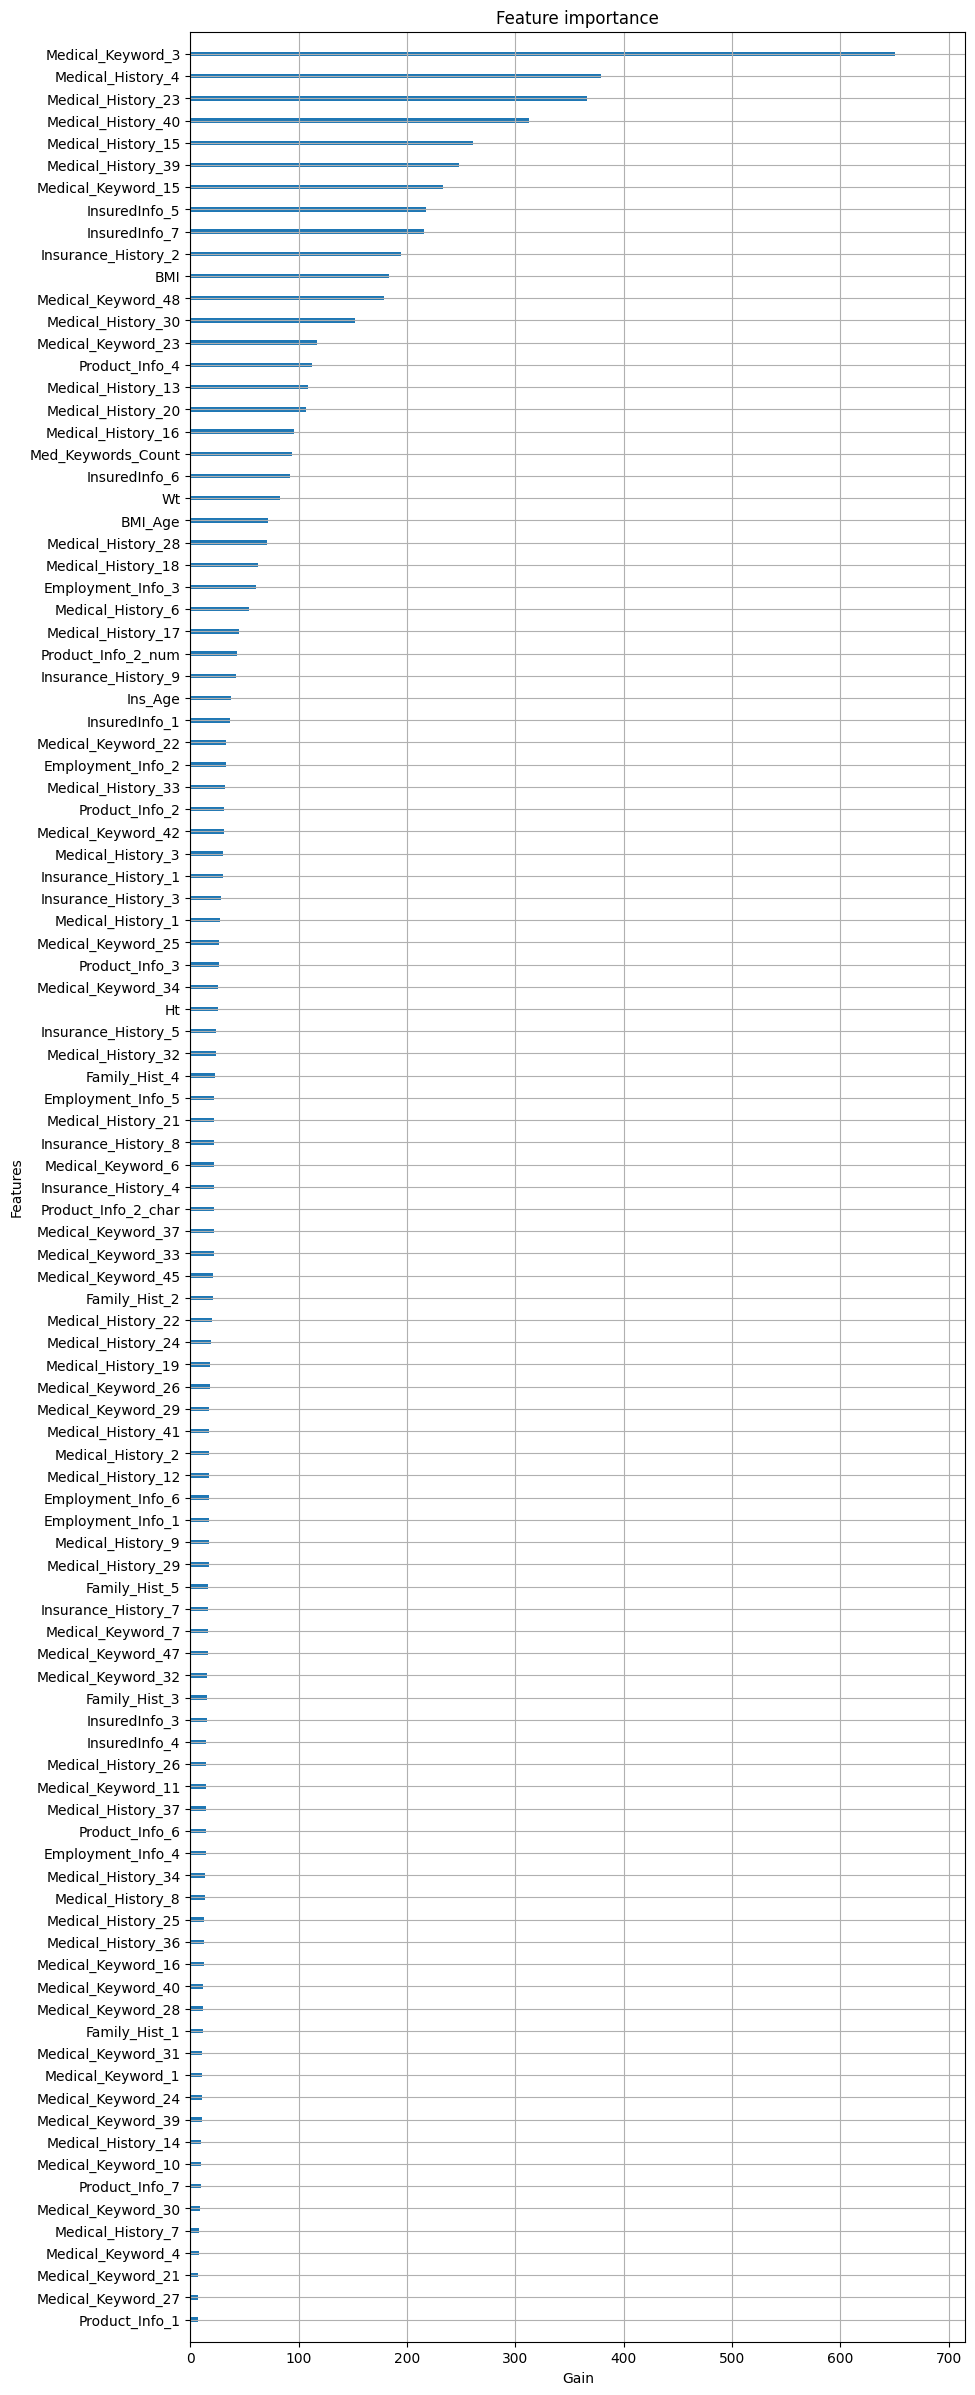

In [18]:
# Visualize feature importance
important_features = model.get_score(importance_type='gain')
important_features = dict(sorted(important_features.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(model, importance_type="gain", xlabel="Gain", show_values=False, ax=ax)
plt.show()


In [21]:
# Feature selection using PCA
pca = PCA()
X_validation_pca = pca.fit_transform(X_valid)

X_validation_component_names = [f"PC{i+1}" for i in range(X_validation_pca.shape[1])]
X_validation_pca = pd.DataFrame(X_validation_pca, columns=X_validation_component_names)
X_validation_loadings = pd.DataFrame(pca.components_.T, columns=X_validation_component_names, index=X_valid.columns)
X_validation_loadings_first = X_validation_loadings.iloc[:, :80]

selected_columns = []

# Visualize which columns in the top PCs contain notable variance
for col in X_validation_loadings_first.columns:
    cols = X_validation_loadings_first[col].loc[abs(X_validation_loadings_first[col]) > 0.25]
    cols_df = pd.DataFrame(cols)
    selected_columns.append(cols_df)

#Count the occurance of each feature in every PC vector.
count_dict = {}

for row in selected_columns:
    for sub_row in row.index:
        if sub_row in count_dict:
            count_dict[sub_row] += 1
        else:
            count_dict[sub_row] = 1

#Sorting features decending, basically features with most count was deemed most imporant by PCA Algorithm.
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))


In [23]:
best_score = 0
optimal_feature_number = 0
best_model = None
scores_list = []

# Feature selection based on the number of features
for features_count in tqdm(range(len(count_dict), 2, -1)):
    filtered_cols = list(count_dict.keys())[:features_count]
    X_train_filtered = X_train[filtered_cols]

    xgtrain = xgb.DMatrix(X_train_filtered, y_train, missing=missing_value_indicator)
    xgb_params_list = get_xgb_params()

    model = xgb.train(xgb_params_list, xgtrain, xgb_num_rounds)
    train_predictions = model.predict(xgtrain)
    current_score = eval_wrapper(train_predictions, y_train)
    scores_list.append(current_score)
    print('Train score for '+str(features_count)+' :', current_score)
    if best_score < current_score:
        best_score = current_score
        optimal_feature_number = features_count
        best_model = model


  0%|                                                                                                                                                                                | 0/92 [00:00<?, ?it/s]/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  1%|█▊                                                                                                                                                                      | 1/92 [00:04<07:07,  4.69s/it]

Train score for 94 : 0.6517501254066507


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  2%|███▋                                                                                                                                                                    | 2/92 [00:09<07:29,  4.99s/it]

Train score for 93 : 0.647270480171877


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  3%|█████▍                                                                                                                                                                  | 3/92 [00:14<07:28,  5.03s/it]

Train score for 92 : 0.6485699782313172


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  4%|███████▎                                                                                                                                                                | 4/92 [00:21<08:01,  5.47s/it]

Train score for 91 : 0.6464935576834767


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  5%|█████████▏                                                                                                                                                              | 5/92 [00:26<07:40,  5.29s/it]

Train score for 90 : 0.6405742381739072


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  7%|██████████▉                                                                                                                                                             | 6/92 [00:28<06:11,  4.32s/it]

Train score for 89 : 0.6405004183345488


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  8%|████████████▊                                                                                                                                                           | 7/92 [00:31<05:20,  3.76s/it]

Train score for 88 : 0.6392766929684655


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
  9%|██████████████▌                                                                                                                                                         | 8/92 [00:34<04:57,  3.54s/it]

Train score for 87 : 0.6400330401733607


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 10%|████████████████▍                                                                                                                                                       | 9/92 [00:38<05:03,  3.66s/it]

Train score for 86 : 0.6373311567219828


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 11%|██████████████████▏                                                                                                                                                    | 10/92 [00:41<04:42,  3.44s/it]

Train score for 85 : 0.6361841117315981


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 12%|███████████████████▉                                                                                                                                                   | 11/92 [00:44<04:28,  3.32s/it]

Train score for 84 : 0.6344024729605111


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 13%|█████████████████████▊                                                                                                                                                 | 12/92 [00:47<04:19,  3.24s/it]

Train score for 83 : 0.6335754998387824


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 14%|███████████████████████▌                                                                                                                                               | 13/92 [00:50<04:11,  3.18s/it]

Train score for 82 : 0.6352660642508572


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 15%|█████████████████████████▍                                                                                                                                             | 14/92 [00:52<03:53,  3.00s/it]

Train score for 81 : 0.6353739542749361


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 16%|███████████████████████████▏                                                                                                                                           | 15/92 [00:55<03:39,  2.85s/it]

Train score for 80 : 0.6341347132682982


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 17%|█████████████████████████████                                                                                                                                          | 16/92 [00:57<03:27,  2.73s/it]

Train score for 79 : 0.6334111546657353


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 18%|██████████████████████████████▊                                                                                                                                        | 17/92 [01:00<03:20,  2.67s/it]

Train score for 78 : 0.6321201250558358


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 20%|████████████████████████████████▋                                                                                                                                      | 18/92 [01:03<03:28,  2.82s/it]

Train score for 77 : 0.6315427727405236


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:09] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 21%|██████████████████████████████████▍                                                                                                                                    | 19/92 [01:05<03:16,  2.69s/it]

Train score for 76 : 0.6320813204808039


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 22%|████████████████████████████████████▎                                                                                                                                  | 20/92 [01:07<03:01,  2.51s/it]

Train score for 75 : 0.6300306602165389


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 23%|██████████████████████████████████████                                                                                                                                 | 21/92 [01:10<02:57,  2.49s/it]

Train score for 74 : 0.6316690764172712


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 24%|███████████████████████████████████████▉                                                                                                                               | 22/92 [01:12<02:48,  2.40s/it]

Train score for 73 : 0.6259433841453567


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 25%|█████████████████████████████████████████▊                                                                                                                             | 23/92 [01:14<02:37,  2.29s/it]

Train score for 72 : 0.6265262181290858


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 26%|███████████████████████████████████████████▌                                                                                                                           | 24/92 [01:16<02:30,  2.21s/it]

Train score for 71 : 0.6250446392168293


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 27%|█████████████████████████████████████████████▍                                                                                                                         | 25/92 [01:18<02:24,  2.15s/it]

Train score for 70 : 0.6247695329350925


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 28%|███████████████████████████████████████████████▏                                                                                                                       | 26/92 [01:20<02:23,  2.18s/it]

Train score for 69 : 0.6232160942677677


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 29%|█████████████████████████████████████████████████                                                                                                                      | 27/92 [01:23<02:28,  2.28s/it]

Train score for 68 : 0.6245945883975332


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 30%|██████████████████████████████████████████████████▊                                                                                                                    | 28/92 [01:25<02:20,  2.20s/it]

Train score for 67 : 0.6229955102397158


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 32%|████████████████████████████████████████████████████▋                                                                                                                  | 29/92 [01:27<02:13,  2.12s/it]

Train score for 66 : 0.6234211355547716


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 33%|██████████████████████████████████████████████████████▍                                                                                                                | 30/92 [01:29<02:08,  2.07s/it]

Train score for 65 : 0.6249856599438719


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 34%|████████████████████████████████████████████████████████▎                                                                                                              | 31/92 [01:31<02:03,  2.03s/it]

Train score for 64 : 0.6192530656888794


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 35%|██████████████████████████████████████████████████████████                                                                                                             | 32/92 [01:33<01:59,  2.00s/it]

Train score for 63 : 0.6108546516183775


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 36%|███████████████████████████████████████████████████████████▉                                                                                                           | 33/92 [01:35<01:56,  1.97s/it]

Train score for 62 : 0.6097557558712621


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 37%|█████████████████████████████████████████████████████████████▋                                                                                                         | 34/92 [01:37<02:04,  2.14s/it]

Train score for 61 : 0.6115517987071641


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 38%|███████████████████████████████████████████████████████████████▌                                                                                                       | 35/92 [01:39<01:58,  2.07s/it]

Train score for 60 : 0.6087392363758344


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 36/92 [01:41<01:52,  2.01s/it]

Train score for 59 : 0.6091585967813766


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 40%|███████████████████████████████████████████████████████████████████▏                                                                                                   | 37/92 [01:43<01:48,  1.97s/it]

Train score for 58 : 0.6097846893829231


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 41%|████████████████████████████████████████████████████████████████████▉                                                                                                  | 38/92 [01:45<01:43,  1.92s/it]

Train score for 57 : 0.5946482085012552


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                | 39/92 [01:46<01:40,  1.89s/it]

Train score for 56 : 0.5939099892001294


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 40/92 [01:48<01:36,  1.86s/it]

Train score for 55 : 0.5929161869335453


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                            | 41/92 [01:50<01:33,  1.83s/it]

Train score for 54 : 0.5937958394885486


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                          | 42/92 [01:52<01:30,  1.81s/it]

Train score for 53 : 0.5942066522488735


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 47%|██████████████████████████████████████████████████████████████████████████████                                                                                         | 43/92 [01:54<01:28,  1.81s/it]

Train score for 52 : 0.5919675759673766


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                       | 44/92 [01:55<01:25,  1.79s/it]

Train score for 51 : 0.5928856796859492


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 45/92 [01:58<01:34,  2.01s/it]

Train score for 50 : 0.5921859953305028


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 46/92 [02:00<01:30,  1.98s/it]

Train score for 49 : 0.5902619237372613


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 47/92 [02:02<01:27,  1.95s/it]

Train score for 48 : 0.5836478755000858


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 48/92 [02:03<01:22,  1.88s/it]

Train score for 47 : 0.5792404262222558


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:09] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 49/92 [02:05<01:18,  1.82s/it]

Train score for 46 : 0.5772738025820956


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 50/92 [02:07<01:16,  1.83s/it]

Train score for 45 : 0.5724948915984401


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 51/92 [02:09<01:18,  1.91s/it]

Train score for 44 : 0.5713734187718678


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 52/92 [02:11<01:23,  2.09s/it]

Train score for 43 : 0.47589647459785334


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 53/92 [02:13<01:20,  2.08s/it]

Train score for 42 : 0.46855515003277914


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 54/92 [02:15<01:13,  1.92s/it]

Train score for 41 : 0.46834592121242746


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 55/92 [02:17<01:06,  1.80s/it]

Train score for 40 : 0.4681718598905825


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 56/92 [02:18<01:00,  1.69s/it]

Train score for 39 : 0.4667535247362671


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 57/92 [02:19<00:56,  1.61s/it]

Train score for 38 : 0.4692124013427057


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/92 [02:21<00:53,  1.57s/it]

Train score for 37 : 0.4625012910477081


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 59/92 [02:22<00:50,  1.53s/it]

Train score for 36 : 0.46176270901163285


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 60/92 [02:24<00:48,  1.52s/it]

Train score for 35 : 0.46135169631236883


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 61/92 [02:25<00:45,  1.48s/it]

Train score for 34 : 0.46062617594512967


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 62/92 [02:27<00:43,  1.46s/it]

Train score for 33 : 0.4567215981638886


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 63/92 [02:29<00:48,  1.67s/it]

Train score for 32 : 0.4525599201070316


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 64/92 [02:30<00:44,  1.58s/it]

Train score for 31 : 0.4517495766093286


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 65/92 [02:32<00:41,  1.52s/it]

Train score for 30 : 0.45182378250909694


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:37] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 66/92 [02:33<00:38,  1.47s/it]

Train score for 29 : 0.44439653628096754


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 67/92 [02:34<00:35,  1.42s/it]

Train score for 28 : 0.4402806199421774


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 68/92 [02:36<00:33,  1.41s/it]

Train score for 27 : 0.43978970806970474


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 69/92 [02:37<00:32,  1.43s/it]

Train score for 26 : 0.43682861445476273


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 70/92 [02:39<00:34,  1.57s/it]

Train score for 25 : 0.4378094106982251


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 71/92 [02:40<00:31,  1.49s/it]

Train score for 24 : 0.4354407756679486


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 72/92 [02:41<00:28,  1.40s/it]

Train score for 23 : 0.421051707699978


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 73/92 [02:43<00:25,  1.34s/it]

Train score for 22 : 0.42081405591128584


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 74/92 [02:44<00:23,  1.32s/it]

Train score for 21 : 0.41021502478394345


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:49] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 75/92 [02:45<00:21,  1.28s/it]

Train score for 20 : 0.40887487156782765


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 76/92 [02:46<00:19,  1.24s/it]

Train score for 19 : 0.401480837329664


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 77/92 [02:48<00:19,  1.29s/it]

Train score for 18 : 0.39866872021462163


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 78/92 [02:49<00:17,  1.26s/it]

Train score for 17 : 0.3743929943369313


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 79/92 [02:50<00:15,  1.20s/it]

Train score for 16 : 0.3656360930502984


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 80/92 [02:51<00:13,  1.15s/it]

Train score for 15 : 0.24866352696282157


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 81/92 [02:52<00:12,  1.12s/it]

Train score for 14 : 0.24819584554267438


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 82/92 [02:53<00:10,  1.07s/it]

Train score for 13 : 0.2463661955576517


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 83/92 [02:54<00:09,  1.04s/it]

Train score for 12 : 0.2433683592243675


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 84/92 [02:55<00:08,  1.02s/it]

Train score for 11 : 0.23935147143856994


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 85/92 [02:56<00:07,  1.01s/it]

Train score for 10 : 0.24005218120947747


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 86/92 [02:57<00:06,  1.02s/it]

Train score for 9 : 0.14556923022609758


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 87/92 [02:58<00:05,  1.19s/it]

Train score for 8 : 0.14357761148828962


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 88/92 [02:59<00:04,  1.05s/it]

Train score for 7 : 0.1148053684885586


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 89/92 [03:00<00:02,  1.12it/s]

Train score for 6 : 0.11192046745114526


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 90/92 [03:00<00:01,  1.36it/s]

Train score for 5 : 0.07139777115612322


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 91/92 [03:00<00:00,  1.58it/s]

Train score for 4 : 0.06786775264804157


/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/shalinijawale/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [03:01<00:00,  1.97s/it]

Train score for 3 : 0.05472009102563802


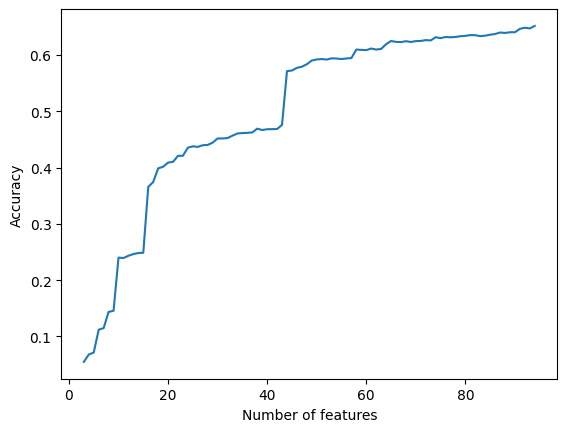

Best score on Train :  0.6517501254066507


In [24]:
#Visualize Train
plt.plot(range(len(count_dict), 2, -1), scores_list)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

print("Best score on Train : ",best_score)


In [26]:
#Accuracy on test
filtered_cols = list(count_dict.keys())[:optimal_feature_number]
X_test_filtered = X_test[filtered_cols]

xgtest = xgb.DMatrix(X_test_filtered, y_test, missing=missing_value_indicator)
test_predictions = best_model.predict(xgtest)
current_score = eval_wrapper(test_predictions,y_test)
print("Accuracy on test : ",current_score)

Accuracy on test :  0.596790390092999


In [27]:
def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int) == sv] = data[0, data[0].astype(int) == sv] + bin_offset
    score = scorer(data[1], data[2])
    return score


def apply_offsets(data, offsets):
    for j in range(num_classes):
        data[1, data[0].astype(int) == j] = data[0, data[0].astype(int) == j] + offsets[j]
    return data


# train offsets
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((test_predictions, test_predictions, y_test))
offset_preds = apply_offsets(offset_preds, offsets)
opt_order = [6, 4, 5, 3]
for j in opt_order:
    test_offset = lambda x: -score_offset(offset_preds, x, j) * 100
    offsets[j] = fmin_powell(test_offset, offsets[j], disp=False)

print('Offset Test score is:', eval_wrapper(offset_preds[1], y_test))

Offset Test score is: 0.6442316947355207


In [30]:
# Import key modules/functions for evaluating model performance.
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score

In [29]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


              precision    recall  f1-score   support

           1       0.28      0.38      0.32       938
           2       0.19      0.27      0.22       924
           3       0.05      0.02      0.03       479
           4       0.12      0.02      0.04      1460
           5       0.14      0.14      0.14      1079
           6       0.20      0.36      0.26      1264
           7       0.25      0.22      0.24      1832
           8       0.73      0.73      0.73      3901

    accuracy                           0.38     11877
   macro avg       0.25      0.27      0.25     11877
weighted avg       0.37      0.38      0.37     11877

Axes(0.125,0.11;0.62x0.77)


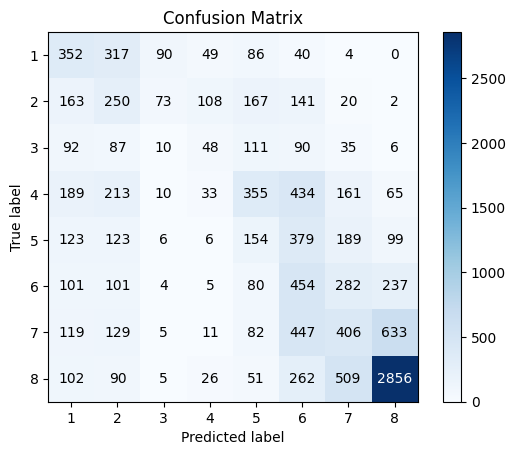

In [31]:
def report(yhat, y):
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
    print(classification_report(yhat,y))
    print(plot_confusion_matrix(yhat, y))
    
report(offset_preds[1],y_test)

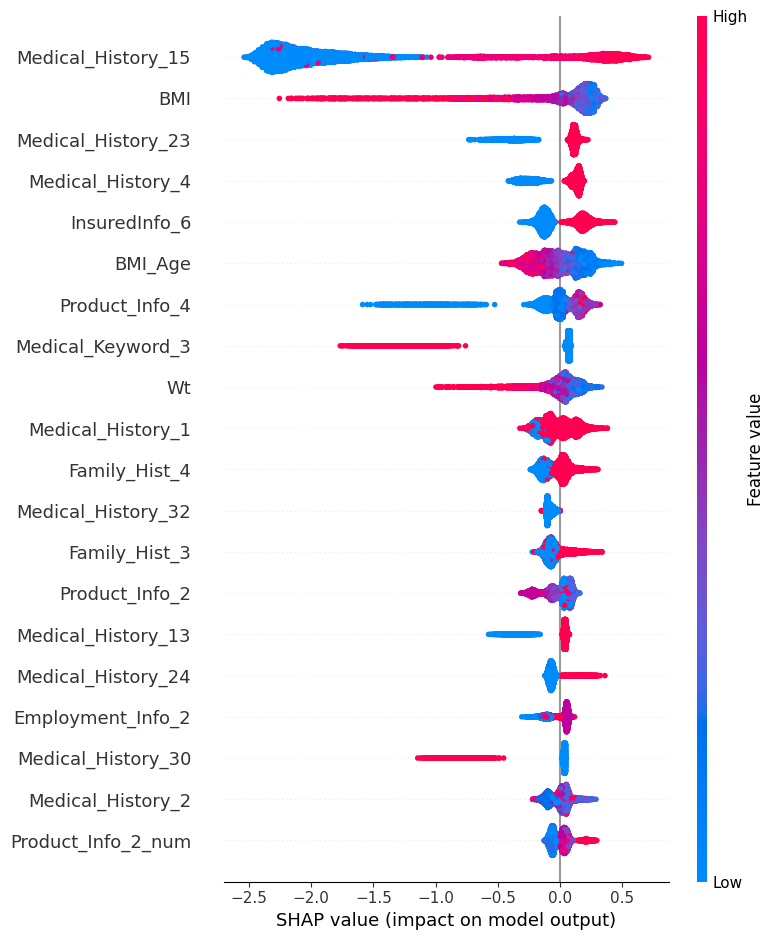

In [35]:
import shap

# Initialise the explainer object in order to calculate SHAP values.
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the whole test dataset.
shap_values = explainer.shap_values(X_test_filtered)

# Create a summary plot of the SHAP values.
shap.summary_plot(shap_values, X_test_filtered)